In [98]:
# Import python libraries
#
import importlib
import pickle
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import torch.nn as nn
from matplotlib.patches import Rectangle
import seaborn as sns
import matplotlib.dates as mdates
from collections import defaultdict
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

# Go one directory back, because all imports are done
# relative to the root of the project.
#
project_root = '..'
if 'change_directory_to_root' not in globals():
    change_directory_to_root = True
    os.chdir(project_root)

# Imports own modules.
#
import scripts.Visualization as Visualization
import scripts.ModelTrainer as ModelTrainer
import scripts.Utils as utils
import scripts.Simulation_config as Simulation_config
from scripts.Simulation_config import *
import models.Model as Model
import scripts.ModelAdapter as ModelAdapter


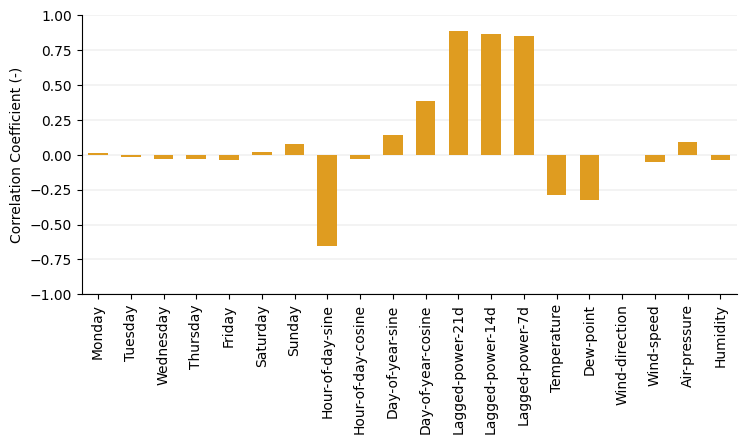

In [25]:
# Evaluate specific model of given power profiles and given configurations
#

importlib.reload(Visualization)
importlib.reload(Model)
importlib.reload(utils)
importlib.reload(ModelAdapter)

# Define a specific configuration
#
community_id = 0  # chose one of many energy communites
myConfig = Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT)

modelTrainer = ModelTrainer.ModelTrainer()
loadProfiles, weatherData, public_holidays_timestamps = modelTrainer.load_data(myConfig)
modelAdapter = ModelAdapter.ModelAdapter(public_holidays_timestamps, 
                                            trainHistory = myConfig.trainingHistory,
                                            testSize = myConfig.testSize, 
                                            trainFuture = myConfig.trainingFuture, 
                                            devSize = myConfig.devSize, 
                                            )
X, Y = modelAdapter.transformData(loadProfiles[community_id], weatherData)

batch, timesteps, features = X['all'].shape

# Flatten across batch and timesteps
x_flat = X['all'].reshape(batch * timesteps, features)
y_flat = Y['all'].reshape(batch * timesteps)

feature_names = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
    'Hour-of-day-sine', 'Hour-of-day-cosine', 'Day-of-year-sine', 'Day-of-year-cosine',
    'Lagged-power-21d', 'Lagged-power-14d', 'Lagged-power-7d',
    'Temperature', 'Dew-point', 'Wind-direction', 'Wind-speed', 'Air-pressure', 'Humidity',
]
assert features == len(feature_names)

# Compute full correlation matrix

df = pd.DataFrame(x_flat, columns=feature_names)
df['Target'] = y_flat
corr = df.corr(numeric_only=True)

# Extract just correlations with the target
target_corr = corr['Target'].drop('Target')  # drop self-correlation
target_corr_df = target_corr.to_frame().rename(columns={'Target': 'correlation'})

# Plot as barplot
fig_width_inch = 190 / 25.4
fig_height_inch = fig_width_inch * 0.6
plt.figure(figsize=(fig_width_inch, fig_height_inch))
ax=plt.gca()

plt.grid(axis='y', linestyle='-', linewidth=0.2, zorder=0)
sns.barplot(x=target_corr_df.index, y=target_corr_df.correlation, color='orange', width=0.6, zorder=2) # , color='lightblue'
# plt.barh(target_corr_df.index, width=target_corr_df.correlation, height=0.8, color='orange')
plt.xticks(rotation=90)
plt.ylabel("Correlation Coefficient (-)")
plt.xlabel("")
plt.tight_layout()
plt.ylim(-1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.axhline(y=0,color='gray', linewidth=0.5)
plt.savefig("scripts/outputs/figs/Figure_6.pdf", format="pdf", bbox_inches="tight")
plt.show()


nMAE = 4.8% of community 0 on test day 3.
nMAE = 36.6% of community 0 on test day 87.


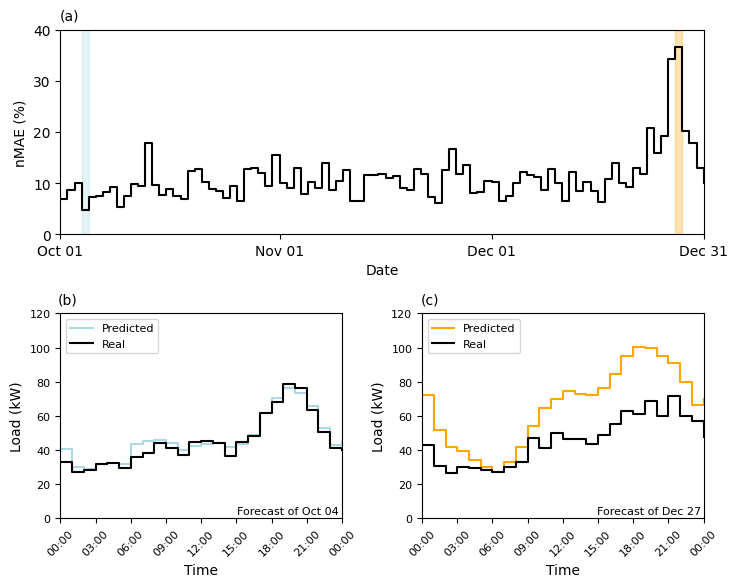

In [202]:
# Create Load Profile Plots
#

importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)

########
# Setup the test setup configuration
#
resuts_filename = 'scripts/outputs/all_train_histories.pkl'
expected_configs = Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
                    NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT)
model_type = 'Transformer'
community_id = 0
start_date = pd.to_datetime("2013-10-01")
end_date = pd.to_datetime("2013-12-31")
########

# Check, if all data are available
# and create a nested dictionary of shape 'profiles_by_community_size[community_size][model][community_id]'
#
profiles_by_community_size = utils.Evaluate_Models.get_testrun_results([expected_configs], resuts_filename)

# Calculate the daily nMAE
#
Y_pred = profiles_by_community_size[expected_configs.aggregation_Count[0]][model_type][community_id]
Y_real = profiles_by_community_size[expected_configs.aggregation_Count[0]]['Perfect'][community_id]
Y_pred = torch.tensor(Y_pred.reshape((-1, 24)))
Y_real = torch.tensor(Y_real.reshape((-1, 24)))
loss_fn = nn.L1Loss(reduction='none')
nMAE = (loss_fn(Y_pred, Y_real).mean(dim=1)) / torch.mean(Y_real).item()
nMAE *= 100    # Convert to %

# Create Plot
fig_width_inch = 190 / 25.4
fig_height_inch = fig_width_inch * 0.8
fig = plt.figure(figsize=(fig_width_inch, fig_height_inch))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Create Sub-Plot
ax1 = plt.subplot(gs[0, :])
date_range = pd.date_range(start=start_date, periods=len(nMAE), freq='D')
ax1.step(date_range, nMAE, where='post', label='nMAE (%)', color='black')
ax1.set_ylabel(f'nMAE (%)', fontsize=10)
date_format = mdates.DateFormatter('%b %d')  # Example: Jan 01, 2024
ax1.xaxis.set_major_formatter(date_format) 
tick_positions = [pd.to_datetime("2013-10-01"), pd.to_datetime("2013-11-01"), pd.to_datetime("2013-12-01"), pd.to_datetime("2013-12-31")] 
ax1.set_xticks(tick_positions)
ax1.set_xlabel(f'Date', fontsize=10)
ax1.set_xlim(start_date, end_date)
ax1.set_ylim(0, 40)

# Find the best and worst days (max and min values in the data)
best_day_index = int(np.argmin(nMAE))
worst_day_index = int(np.argmax(nMAE))
best_day = date_range[best_day_index]
worst_day = date_range[worst_day_index]
ax1.axvspan(best_day, best_day+pd.Timedelta(days=1), color='lightblue', alpha=0.3, label="Best Forecast")
ax1.axvspan(worst_day, worst_day+pd.Timedelta(days=1), color='orange', alpha=0.3, label="Worst Forecast")

# Add (a) and (b) lables to the figure
ax1.text(0.03, 1.1, '(a)', transform=ax1.transAxes, fontsize='medium', va='top', ha='right')




########
# Setup the test setup configuration
#
resuts_filename = 'scripts/outputs/all_train_histories.pkl'
expected_configs = Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
                    NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT)
model_type = 'Transformer'
community_id = 0
startdate = pd.Timestamp('2013-10-01 00:00:00+00:00')
days_to_plot = ['2013-10-04', '2013-12-27']
########

print(f"nMAE = {nMAE[best_day_index].item():.1f}% " \
        f"of community {community_id} on test day {best_day_index}.")
print(f"nMAE = {nMAE[worst_day_index].item():.1f}% " \
        f"of community {community_id} on test day {worst_day_index}.")

# Check, if all data are available
# and create a nested dictionary of shape 'profiles_by_community_size[community_size][model][community_id]'
#
profiles_by_community_size = utils.Evaluate_Models.get_testrun_results([expected_configs], resuts_filename)

# Calculate the daily nMAE
#
Y_pred = profiles_by_community_size[expected_configs.aggregation_Count[0]][model_type][community_id]
Y_real = profiles_by_community_size[expected_configs.aggregation_Count[0]]['Perfect'][community_id]

# Create dataframe
datetime_index = pd.date_range(start=startdate, periods=Y_real.shape[0], freq='1h')
df_Y_plot = pd.DataFrame()
df_Y_plot['x'] = datetime_index
df_Y_plot['Y_real'] = Y_real / 1000.0
df_Y_plot['Y_pred'] = Y_pred / 1000.0

for i, day_to_plot in enumerate(days_to_plot):

        ax2 = plt.subplot(gs[1, i], sharey=ax2)

        # Plot only given Day
        day_start = pd.to_datetime(day_to_plot).tz_localize('UTC')
        day_end = day_start + pd.Timedelta(days=1)
        mask = (df_Y_plot['x'] >= day_start) & (df_Y_plot['x'] <= day_end)
        df_Y_plot_day = df_Y_plot[mask]

        ax2.step(df_Y_plot_day['x'], df_Y_plot_day['Y_pred'], where='post', label='Predicted', color=['lightblue','orange',][i])
        ax2.step(df_Y_plot_day['x'], df_Y_plot_day['Y_real'], where='post', label='Real', color='black')
        ax2.set_ylabel(f'Load (kW)', fontsize=10)
        ax2.set_xlabel(f'Time', fontsize=10)
        ax2.tick_params(axis='both', which='major', labelsize=8)
        ax2.legend(loc='upper left', fontsize=8)
        ax2.xaxis.set_major_locator(mdates.HourLocator(interval=3))
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax2.set_xlim(day_start, day_end)
        ax2.set_ylim(0, 120)
        ax2.tick_params(axis='x', rotation=45)

        # Print prediction date
        ax2.text(0.99, 0.01, f'Forecast of {pd.to_datetime(day_to_plot).strftime("%b %d")}', 
                transform=ax2.transAxes,
                ha='right', va='bottom',
                fontsize=8, color='black')        
        
        # Add (b) and (c) lables to the figure
        ax2.text(0.06, 1.1, ['(b)','(c)'][i], transform=ax2.transAxes, fontsize='medium', va='top', ha='right')

# Save plot
# fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('scripts/outputs/figs/Figure_7.pdf', format='pdf', dpi=300)
plt.show()


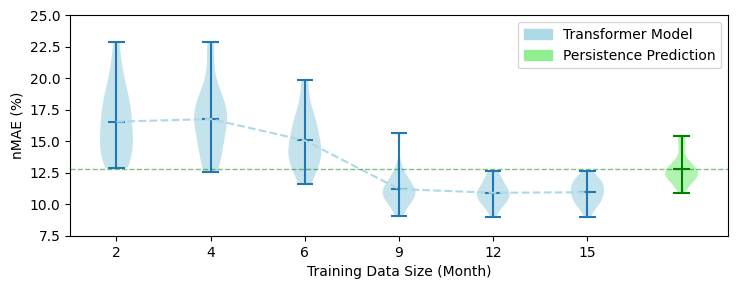

In [28]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)

########
# Setup the test setup configuration
#
resuts_filename = 'scripts/outputs/all_train_histories.pkl'
configs = [
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT), 
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),       
]

machine_learning_model = 'Transformer'
basic_model = 'Persistence'
training_sizes = ['2', '4', '6', '9', '12', '15']
########

# Check, if all data are available
# and create a nested dictionary of shape 'profiles[community_size][model][community_id]'
#
profiles = utils.Evaluate_Models.get_testrun_results(configs, resuts_filename, given_key = 'trainingSize', value_type = 'nMAE')

# Create a list of lists, as needed for the violine plot.
data_with_ML_model = [profiles[trainingsize][machine_learning_model] for trainingsize in profiles]
data_with_basic_model = [profiles[trainingsize][basic_model] for trainingsize in profiles][0]

# Creating subplots for violin plots
fig_width_inch = 190 / 25.4
fig_height_inch = fig_width_inch /2.5
fig, ax = plt.subplots(1, 1, figsize=(fig_width_inch, fig_height_inch), sharex=True, sharey=True)

# Violin of the machine learning model
positions = np.array(range(len(training_sizes))) * 2.0   
violins_ml_model = ax.violinplot(data_with_ML_model, positions=positions, widths=0.7, 
                                showmeans=True, showextrema=True, showmedians=False) 
# Violin of the basic model
violins_basic_models = ax.violinplot(data_with_basic_model, positions=[positions[0] + 12], widths=0.7, 
                                showmeans=True, showextrema=True, showmedians=False)

# Connect the means
data_with_ML_model = np.array(data_with_ML_model)
mean_data_with_ML_model = np.mean(data_with_ML_model, axis=1)
ax.plot(positions, mean_data_with_ML_model, label=f'{model} Model',
            linestyle='--', marker='', color='lightblue')  # training_sizes,        

# Set custom colors for the violins and vertical lines
for pc in violins_ml_model['bodies']:
    pc.set_facecolor("lightblue")
    pc.set_alpha(0.7)
for pc in violins_basic_models['bodies']:
    pc.set_facecolor("lightgreen")
    pc.set_alpha(0.7)
violins_basic_models['cmeans'].set_color('green')   # Change the color of the mean lines
violins_basic_models['cmins'].set_color('green')   # Change the color of the minimum lines
violins_basic_models['cmaxes'].set_color('green')  # Change the color of the maximum lines
violins_basic_models['cbars'].set_color('green')  # Change the color of the vertical bars (connectors)

# Add horizontal lines for the computed mean
mean_basic = np.mean(data_with_basic_model)    
ax.axhline(mean_basic, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Mean of Basic Model')

# Labels and title
ax.set_ylabel('nMAE (%)')
ax.set_ylim(7.5, 25)
ax.set_xticks(positions)
ax.set_xticklabels(training_sizes)
ax.set_axisbelow(True)
legend_patches = [
    Patch(color="lightblue", label=f"{model} Model"),
    Patch(color="lightgreen", label="Persistence Prediction")
]
ax.legend(handles=legend_patches, loc="upper right")
ax.set_xlabel('Training Data Size (Month)')
plt.tight_layout()
plt.savefig("scripts/outputs/figs/Figure_8.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


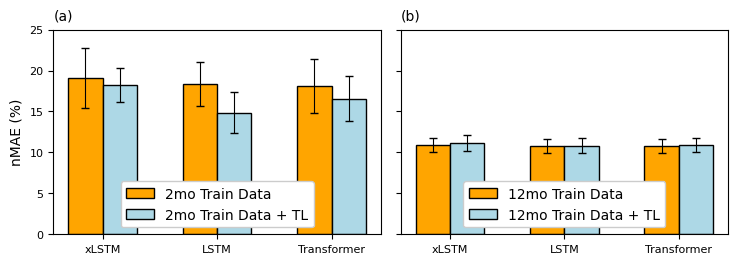

Average Improvement due to transfer learning: 1.97%.


In [29]:
# Compare with and without transfer learning of the given configurations 
#

importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)

########
# Setup the test setup configuration
#
resuts_filename = 'scripts/outputs/all_train_histories.pkl'
configs = [
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT), 
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),       
    
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),  
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
]

models = ('xLSTM', 'LSTM', 'Transformer', )
configs_with_transfer = configs[0:6]
configs_without_transfer = configs[6:12]
training_sizes = ['2', '4', '6', '9', '12', '15']
########

# Check, if all data are available
# and create a nested dictionary of shape 'profiles[trainingSize][model][community_id]'
#
profiles_w_transfer = utils.Evaluate_Models.get_testrun_results(configs_with_transfer, resuts_filename, given_key = 'trainingSize', value_type = 'nMAE')
profiles_wo_transfer = utils.Evaluate_Models.get_testrun_results(configs_without_transfer, resuts_filename, given_key = 'trainingSize', value_type = 'nMAE')


# Create bar plot with error bars
fig_width_inch = 190 / 25.4
fig_height_inch = 70 / 25.4
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(fig_width_inch, fig_height_inch), sharey=True)

for i, (month, days) in enumerate([('2mo', 61), ('12mo', 365)]):
        
        # Calculate the average improvement with tranfer learning
        mean_values_w_transfer, mean_values_wo_transfer = [], []
        std_w_transfer, std_wo_transfer = [], []
        for model in models:
                mean_values_w_transfer.append(np.mean(profiles_w_transfer[days][model]))
                mean_values_wo_transfer.append(np.mean(profiles_wo_transfer[days][model]))
                std_w_transfer.append(np.std(profiles_w_transfer[days][model]))
                std_wo_transfer.append(np.std(profiles_wo_transfer[days][model]))
        
        # Create the barplot
        x = np.arange(len(models))
        width = 0.3
        ax[i].bar(x - width/2, mean_values_wo_transfer, width, 
        color='orange', edgecolor='black', label=month+' Train Data',
        yerr=std_wo_transfer, capsize=3, error_kw=dict(lw=0.8))
        ax[i].bar(x + width/2, mean_values_w_transfer, width, 
        color='lightblue', edgecolor='black', label=month+' Train Data + TL',
        yerr=std_w_transfer, capsize=3, error_kw=dict(lw=0.8))

        # Axis labels and ticks
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(models, fontsize=8)
        ax[i].tick_params(axis='y', labelsize=8)
        ax[i].legend(framealpha=1.0, loc='lower center')   

        # Add (a) and (b) lables to the figure
        ax[i].text(0.06, 1.1, ['(a)','(b)'][i], transform=ax[i].transAxes, fontsize='medium', va='top', ha='right')

# Layout and save
ax[0].set_ylabel('nMAE (%)', fontsize=10)
ax[0].set_ylim(0, 25)
plt.tight_layout()
fig.savefig('scripts/outputs/figs/Figure_9.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Print the average improvements of transfer learning
mean_values = []
for days in [61]:
        for model in ['xLSTM', 'LSTM', 'Transformer']:
                mean_values.append(np.mean(profiles_wo_transfer[days][model])-np.mean(profiles_w_transfer[days][model]))
print(f'Average Improvement due to transfer learning: {np.mean(mean_values):.2f}%.')


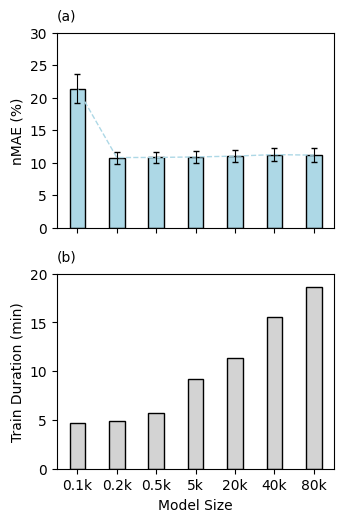

In [30]:
# Compare the effect of the model sizes
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)

########
# Setup the test setup configuration
#
resuts_filename = 'scripts/outputs/all_train_histories.pkl'
configs = [
    Config_of_one_run(ModelSize._0k1, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._0k2, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._0k5, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
#     Config_of_one_run(ModelSize._1k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
#             TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
#     Config_of_one_run(ModelSize._2k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
#             TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
#     Config_of_one_run(ModelSize._10k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
#             TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._20k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._40k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._80K, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
]
model = 'Transformer'
########

# Check, if all data are available
# and create a nested dictionary of shape 'profiles[modelSize][model][community_id]'
#
profiles = utils.Evaluate_Models.get_testrun_results(configs, resuts_filename, given_key = 'modelSize', value_type = 'nMAE')

# Calculate the average improvement with tranfer learning
#
mean_values, std_values = [], []
modelSizes = []
for modelSize in profiles:
        values = profiles[modelSize][model]
        assert len(values) == 20, f'Unexpected nr of communities: {len(values)}'
        modelSizes.append(modelSize)
        mean_values.append(np.mean(values))
        std_values.append(np.std(values))
       
# Define figure size
fig_width_inch = 90 / 25.4
fig_height_inch = fig_width_inch * 0.75 * 2
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(fig_width_inch, fig_height_inch), sharex=True)

# Plot with error bars
ax[0].plot(mean_values, '--', color='lightblue', linewidth=1.0)
ax[0].bar(modelSizes, mean_values, width=0.4, 
       color='lightblue', edgecolor='black', label='Train with 2mo Data + TL',
       yerr=std_values, capsize=2, error_kw=dict(lw=0.8))
ax[0].set_ylabel('nMAE (%)', fontsize=10)
ax[0].set_ylim(bottom=0, top=30)
ax[0].text(0.07, 1.12, '(a)', transform=ax[0].transAxes, fontsize='medium', va='top', ha='right')

# Plot training durations
durations = [4.71, 4.88, 5.72,  9.15, 11.35, 15.55, 18.68]      # Measured with the script in "Model_Evaluation.ipynb"
ax[1].bar(modelSizes, durations, width=0.4, 
       color='lightgrey', edgecolor='black')
ax[1].set_ylabel('Train Duration (min)', fontsize=10)
ax[1].set_ylim(bottom=0, top=20)
ax[1].text(0.07, 1.12, '(b)', transform=ax[1].transAxes, fontsize='medium', va='top', ha='right')
ax[1].set_xlabel('Model Size', fontsize=10)

plt.tight_layout()
plt.savefig('scripts/outputs/figs/Figure_10.pdf', format='pdf')
plt.show()


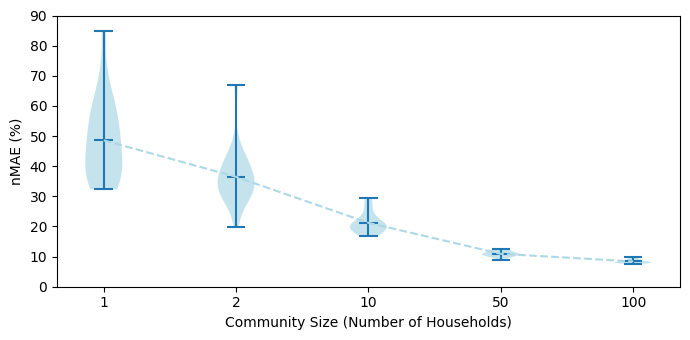

In [31]:
# Compare forecast error over increasing aggregation level
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)

########
# Setup the test setup configuration
#
resuts_filename = 'scripts/outputs/all_train_histories.pkl'
configs = [
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    ]
model = 'Transformer'
household_sizes = ['1', '2', '10', '50', '100']
########

# Check, if all data are available
# and create a nested dictionary of shape 'profiles[community_size][model][community_id]'
#
profiles = utils.Evaluate_Models.get_testrun_results(configs, resuts_filename, given_key = 'community_size', value_type = 'nMAE')

# Create a list of lists, as needed for the violine plot.
data = [profiles[trainingsize][model] for trainingsize in profiles]

# Creating subplots for each household size
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5), sharex=True, sharey=False)

# Plot violin plot
positions = np.array(range(len(household_sizes)))
violins = ax.violinplot(data, positions=positions, widths=0.28, 
                        showmeans=True, showextrema=True, showmedians=False)

for pc in violins['bodies']:
    pc.set_facecolor("lightblue")
    # pc.set_edgecolor("black")
    pc.set_alpha(0.7)
    
# Connect the means
data_with_ML_model = np.array(data)
mean_data_with_ML_model = np.mean(data_with_ML_model, axis=1)
ax.plot(positions, mean_data_with_ML_model, linestyle='--', marker='', color='lightblue')

# Labels and title
ax.set_ylabel('nMAE (%)')
# ax.set_title(f"Transformer Model")
# ax.text(0.5, 0.9, f"Transformer Model", transform=ax.transAxes, fontsize=12, ha="center", va="center")
ax.set_xticks(positions)
ax.set_xticklabels(household_sizes)
ax.set_axisbelow(True)
# ax.grid(True, color="0.9")
ax.set_ylim(0, 90)
ax.set_xlabel('Community Size (Number of Households)')
plt.tight_layout()
plt.savefig("scripts/outputs/figs/Figure_11.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


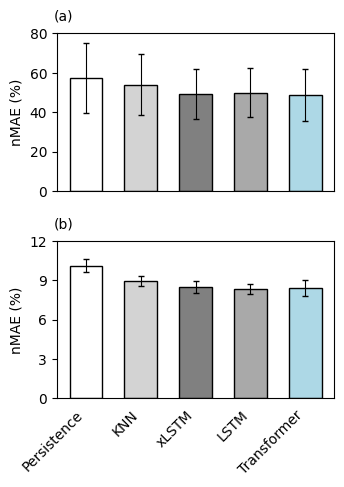

In [216]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)


########
# Setup the test setup configuration
#
resuts_filename = 'scripts/outputs/all_train_histories.pkl'
configs = [
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
#     Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
#             TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
#     Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
#             TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
#     Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
#             TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    ]
models = ('Persistence', 'KNN', 'xLSTM', 'LSTM', 'Transformer', )
figure_lables = ['1 Household', '2 Households', '10 Households', '50 Households', '100 Households']
########

# Check, if all data are available
# and create a nested dictionary of shape 'profiles[community_size][model][community_id]'
#
profiles = utils.Evaluate_Models.get_testrun_results(configs, resuts_filename, given_key = 'community_size', value_type = 'nMAE')

mean_values, std_values = defaultdict(list), defaultdict(list)
for trainingsize in profiles:
        for model in models:
                values = profiles[trainingsize][model]
                assert len(values) == 20, f'Unexpected nr of communities: {len(values)}'
                mean_values[trainingsize].append(np.mean(values))
                std_values[trainingsize].append(np.std(values))

# Plot
fig_width_inch = 90 / 25.4
fig_height_inch = 5
fig, axes = plt.subplots(len(profiles), 1, figsize=(fig_width_inch, fig_height_inch), sharex=True)

for idx, trainingsize in enumerate(profiles):
    ax = axes[idx]
    bars = ax.bar(models, mean_values[trainingsize], yerr=std_values[trainingsize], width=0.6,
           edgecolor='black', capsize=2, error_kw=dict(lw=0.8),
           color=['white', 'lightgrey', 'grey', 'darkgrey', 'lightblue']
           )
    
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)    
    ax.text(0.06, 1.15, ['(a)','(b)'][idx], transform=ax.transAxes, fontsize='medium', va='top', ha='right')
    ax.set_ylabel('nMAE (%)')
    
axes[1].set_xticks(range(len(models)))
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)  

axes[0].set_ylim(0, 80)
axes[1].set_ylim(0, 12)
axes[1].yaxis.set_major_locator(MaxNLocator(nbins=5,integer=True))
plt.tight_layout()
plt.savefig('scripts/outputs/figs/Figure_12.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [33]:
# Create a latex table, containing all informations of the whole experiment
#

# Get specific results
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)

# Get all results
# and create a nested dictionary of shape 'result_dict[config][model][community_id]'
#
result_dict_raw = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', value_type = 'nMAE')

# Display only the defined models (i.e. filter out unneeded models)
used_models = {'Persistence', 'KNN', 'xLSTM', 'LSTM', 'Transformer'}
result_dict = defaultdict(dict)
for config in result_dict_raw:
    for model in result_dict_raw[config]:
        if model in used_models:
            result_dict[config][model] = result_dict_raw[config][model]

# Define the printed configs
printed_configs = [
        
    # Vary the model sizes
    Config_of_one_run(ModelSize._0k1, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._0k2, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._0k5, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._20k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._40k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._80K, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    
   # Vary the tested quartals
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._0_MONTH, TestSize._3_MONTH, TrainingFuture._9_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._3_MONTH, TestSize._3_MONTH, TrainingFuture._6_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._3_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),

    # Vary the community sizes
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),

   # Vary the train set size
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
]

# Create Table "with Transfer Learning"
config_names = ['0.1k', '0.2k', '0.5k', '5k', '20k', '40k', '80k', 
                'Q1', 'Q2', 'Q3', 'Q4',
                '1', '2', '10', '50', '100',
                '2 mo', '4 mo', '6 mo', '9 mo', '12 mo', '15 mo',
                ]
config_groups = [{'name':'Model Size', 'rows':7}, '-', '-', '-', '-', '-', '-', 
                {'name':'Testset<br>(2013)', 'rows':4}, '-', '-', '-',
                {'name':'Community<br>Size', 'rows':5}, '-', '-', '-', '-',
                {'name':'Training Size', 'rows':6}, '-', '-', '-', '-', '-',
                ]
configs_with_transfer_learning = printed_configs[:len(config_names)]
assert len(config_names) == len(config_groups) == len(configs_with_transfer_learning), \
        f"Unexpected list length: {len(config_names)} != {len(config_groups)} != {len(configs_with_transfer_learning)}"
utils.Evaluate_Models.print_latex_table(result_dict, configs_with_transfer_learning, config_groups, config_names)


# Without transfer learning:
#

# Define the printed configs
printed_configs = [
    
    # Vary the train set size
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize._5k, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
]

# Create Table "without Transfer Learning"
config_names = [
                '2 mo', '4 mo', '6 mo', '9 mo', '12 mo', '15 mo',
                ]
config_groups = [
                {'name':'Training Size', 'rows':6}, '-', '-', '-', '-', '-',
                ]
assert len(config_names) == len(config_groups) == len(printed_configs), \
        f"Unexpected list length: {len(config_names)} != {len(config_groups)} != {len(printed_configs)}"
utils.Evaluate_Models.print_latex_table(result_dict, printed_configs, config_groups, config_names)


\hline
\multirow{7}{*}{\rotatebox[origin=c]{90}{\textbf{Model Size}}} 
    & 0.1k & \textbf{11.24} (0.93) & 12.79 (1.13) & nan (nan) & 19.18 (1.82) & 21.39 (2.21) \\ 
    & 0.2k & 11.24 (0.93) & 12.79 (1.13) & nan (nan) & 11.82 (0.97) & \textbf{10.82} (0.92) \\ 
    & 0.5k & 11.24 (0.93) & 12.79 (1.13) & nan (nan) & 10.91 (1.00) & \textbf{10.83} (0.83) \\ 
    & 5k & 11.24 (0.93) & 12.79 (1.13) & 11.16 (1.00) & \textbf{10.84} (0.92) & 10.91 (0.91) \\ 
    & 20k & 11.24 (0.93) & 12.79 (1.13) & 11.79 (0.88) & 11.55 (0.95) & \textbf{11.04} (0.97) \\ 
    & 40k & \textbf{11.24} (0.93) & 12.79 (1.13) & 12.60 (1.16) & 11.90 (0.85) & 11.27 (0.99) \\ 
    & 80k & 11.24 (0.93) & 12.79 (1.13) & 12.53 (1.11) & 12.46 (1.23) & \textbf{11.19} (1.10) \\ 
\hline
\multirow{4}{*}{\rotatebox[origin=c]{90}{\shortstack{\textbf{Testset} \\ \textbf{(2013)}}}} 
    & Q1 & 13.70 (1.57) & 14.02 (1.64) & 12.25 (1.66) & 12.48 (1.52) & \textbf{11.73} (1.69) \\ 
    & Q2 & 14.12 (1.31) & 14.54 (1.01) & 12.41 (1.37)